### Import packages and library

In [1]:
# Common imports
import numpy as np
import os, time
import pandas as pd
import sys
import sklearn

# Our new Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from keras import datasets

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns; sns.set()

# make it reproducible code
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Check the versions both should be 2 or more
print(tf.__version__)

2.14.0


In [3]:
# Check if any GPU devices are available
if tf.test.gpu_device_name():
    print("GPU is available")
    print("GPU device name:", tf.test.gpu_device_name())
else:
    print("No GPU is available")

GPU is available
GPU device name: /device:GPU:0


### Loading and initial processing of the dataset

<img src="CIFAR-10.png" alt="CIFAR-10 dataset" width="600">
We will use CIFAR-10 dataset. The CIFAR-10 dataset (Canadian Institute for Advanced Research, 10 classes) is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. The images are labelled with one of 10 mutually exclusive classes: airplane, automobile (but not truck or pickup truck), bird, cat, deer, dog, frog, horse, ship, and truck (but not pickup truck). There are 6000 images per class with 5000 training and 1000 testing images per class.

<b>Reference<b>:
    
Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

In [4]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [5]:
# Check the size of the dataset
# The number 3 is the number of channels or color channels in the images usually RGB. In this context,
# where each pixel has three color channels: Red, Green, and Blue.
# These color channels are used to represent the colors of each pixel in the image.

# It has 1032 columns with the first column is a target variable named "label"
# 784 columns represents a single 28x28 pixel image with grayscale values between 0-255.
print(train_images.shape)
print(test_images.shape)
n_total = train_images.shape[0]
print()
print("Number of rows in training dataset:",n_total)

(50000, 32, 32, 3)
(10000, 32, 32, 3)

Number of rows in training dataset: 50000


In [6]:
# Assuming you have class names (you can get these from CIFAR-10 documentation)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Count the occurrences of each class label in train_labels
train_class_counts = {class_name: np.sum(train_labels == i) for i, class_name in enumerate(class_names)}

# Count the occurrences of each class label in test_labels
test_class_counts = {class_name: np.sum(test_labels == i) for i, class_name in enumerate(class_names)}

# Print the counts for each class in train_labels
print("Train Class Counts:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} samples")

# Print the counts for each class in test_labels
print("\nTest Class Counts:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} samples")


Train Class Counts:
airplane: 5000 samples
automobile: 5000 samples
bird: 5000 samples
cat: 5000 samples
deer: 5000 samples
dog: 5000 samples
frog: 5000 samples
horse: 5000 samples
ship: 5000 samples
truck: 5000 samples

Test Class Counts:
airplane: 1000 samples
automobile: 1000 samples
bird: 1000 samples
cat: 1000 samples
deer: 1000 samples
dog: 1000 samples
frog: 1000 samples
horse: 1000 samples
ship: 1000 samples
truck: 1000 samples


In [7]:
# Split data in validation (10000) and train (40000).
# A good starting point is to normalize the pixel values of RGB images, e.g. rescale them to the range [0,1].
# This involves first converting the data type from unsigned integers to floats,
# then dividing the pixel values by the maximum value.
# Scale the data appropriately (it starts with max of 255, but we want max of 1)

# Split the data for X_train, X_val and X_test
X_test = test_images/255
X_val, X_train = train_images[:10000]/255, train_images[10000:]/255

# The same, but for y.
y_test = test_labels
y_val, y_train = train_labels[:10000], train_labels[10000:]

automobile


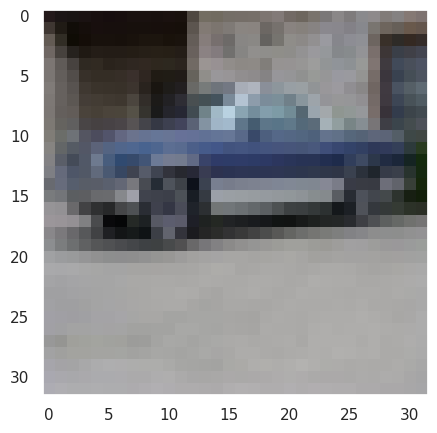

frog


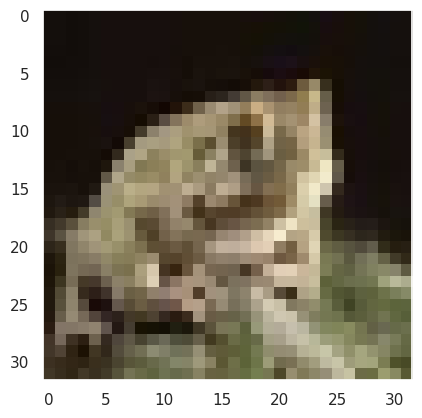

frog


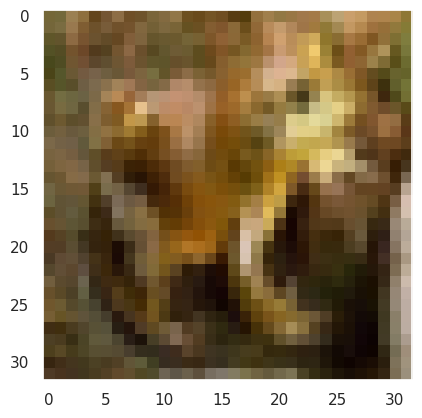

ship


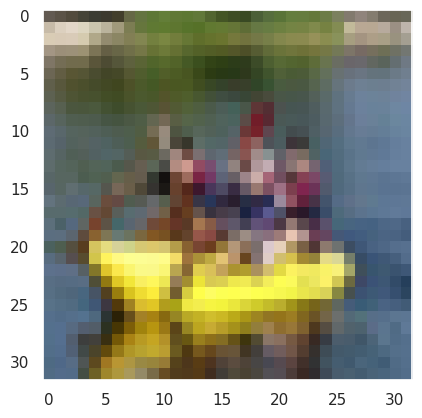

ship


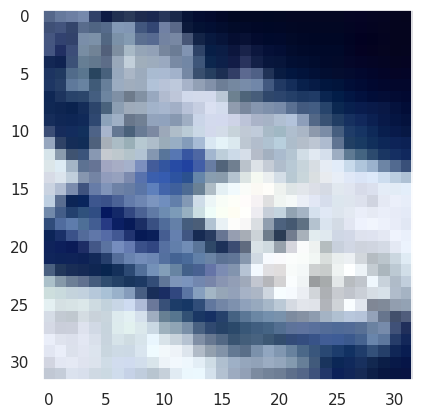

In [8]:
# Display the dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(5,5))

list_names = range(0,5)
for i in list_names:
    print(class_names[y_train[i][0]])
    plt.imshow(X_train[i])
    plt.grid(False)
    plt.show()

In [9]:
from keras.utils import to_categorical

# We also know that there are 10 classes and that classes are represented as characters
# We can, therefore, use a one hot encoding for the class element of each sample,
# transforming the characters into a 10 element binary vector with a 1 for the index of the class value,
# and 0 values for all other classes. We can achieve this with the to_categorical() utility function.

# one hot encode target values
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [10]:
# Import from Keras library to build Convolutional Neural Network (CNN) model for image classification
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import Adam

### Building a CNN

The model has two main aspects: the feature extraction front end comprised of <B>convolutional</B> and <b> pooling layers</b>, and the classifier backend that will make a prediction.

<img src="Basic_CNN.png" alt="Basic_CNN" width="600">

This basic CNN consists of two repeated blocks of Convolution and Max Pooling,
following by two Fully Connected layers. As discussed in a previous section, the
<b>convolution and max pooling layers are responsible for learning the spatial characteristics
of the classes</b> (for example, identifying the ears of cats), whereas the <b>Fully Connected layers
learn to make predictions using these spatial characteristics</b>.


For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 128 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.


### Baseline Model

Epoch 1/10
2500/2500 [==============================] - 43s 10ms/step - loss: 1.6137 - accuracy: 0.4131 - val_loss: 1.3367 - val_accuracy: 0.5135
Epoch 2/10
2500/2500 [==============================] - 18s 7ms/step - loss: 1.2309 - accuracy: 0.5613 - val_loss: 1.0971 - val_accuracy: 0.6113
Epoch 3/10
2500/2500 [==============================] - 21s 9ms/step - loss: 1.0290 - accuracy: 0.6369 - val_loss: 0.9949 - val_accuracy: 0.6533
Epoch 4/10
2500/2500 [==============================] - 18s 7ms/step - loss: 0.8878 - accuracy: 0.6863 - val_loss: 0.9502 - val_accuracy: 0.6624
Epoch 5/10
2500/2500 [==============================] - 27s 11ms/step - loss: 0.7761 - accuracy: 0.7281 - val_loss: 0.8665 - val_accuracy: 0.6953
Epoch 6/10
2500/2500 [==============================] - 24s 9ms/step - loss: 0.6843 - accuracy: 0.7609 - val_loss: 0.8394 - val_accuracy: 0.7152
Epoch 7/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.5947 - accuracy: 0.7931 - val_loss: 0.8122 - val_

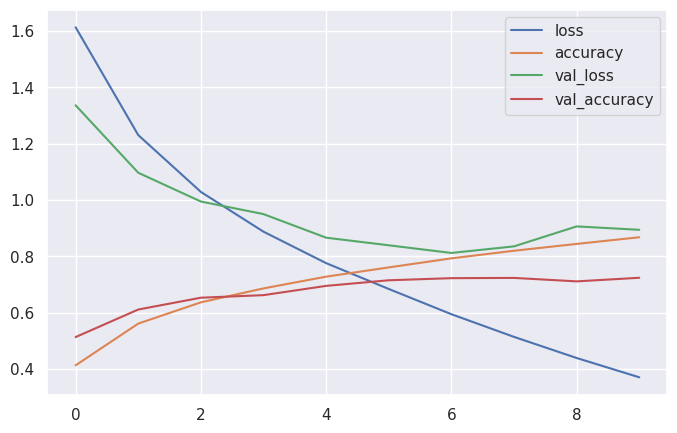

Test loss: 0.9304194450378418, Baseline model accuracy: 0.718500018119812


In [11]:
# Baseline model
# minimum model performance to which all of our other models can be compared,
# as well as a model architecture that we can use as the basis of study and improvement.
# we will use and adapt the VGG architectural models
# i chose VGG because it achieved a good performance in the ILSVRC 2014 competition
# not just that, the architetural model is simple and easy to understand
# read the paper
# the model involves stacking of convulutional layers with small 3X3 filter
# followed by max pooling layer.
# Together, these layers form a block, and
# these blocks can be repeated where the number of filters in each block is
# increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model.
# Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs.
# each layer will use ReLU activation function and the HE weight initialzation which are best practice


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

# feature maps output from the feature extraction part of the model must be flattened.
# We can then interpret them with one or more fully connected layers,
# and then output a prediction. The output layer must have 10 nodes for the
# 10 classes and use the softmax activation function.

# example output part of the model
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Now train (fit) the model, specifying appropriate data and number of epochs (small here to save time)
# Save the history of metrics versus epochs - *always* keep this
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=16)

# Simple way to plot the history information (see later for more detail)
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.show()

# Now run the model on the test set and get results (loss and accuracy both reported)
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss}, Baseline model accuracy: {test_accuracy}")

# hese results suggest that the model with three VGG blocks
# is a good starting point or baseline model for our investigation.

# results also suggest that the model is in need of regularization to address the
# rapid overfitting of the test dataset. More generally, the results suggest that i
# it may be useful to investigate techniques that slow down the convergence (rate of learning) of the model

### Baseline + Dropout Model

Epoch 1/20
2500/2500 [==============================] - 30s 11ms/step - loss: 1.8497 - accuracy: 0.3142 - val_loss: 1.4929 - val_accuracy: 0.4526
Epoch 2/20
2500/2500 [==============================] - 25s 10ms/step - loss: 1.4646 - accuracy: 0.4654 - val_loss: 1.2591 - val_accuracy: 0.5484
Epoch 3/20
2500/2500 [==============================] - 17s 7ms/step - loss: 1.2658 - accuracy: 0.5436 - val_loss: 1.0930 - val_accuracy: 0.6123
Epoch 4/20
2500/2500 [==============================] - 17s 7ms/step - loss: 1.1214 - accuracy: 0.6005 - val_loss: 0.9860 - val_accuracy: 0.6450
Epoch 5/20
2500/2500 [==============================] - 18s 7ms/step - loss: 1.0138 - accuracy: 0.6417 - val_loss: 0.8993 - val_accuracy: 0.6772
Epoch 6/20
2500/2500 [==============================] - 18s 7ms/step - loss: 0.9365 - accuracy: 0.6668 - val_loss: 0.8313 - val_accuracy: 0.7073
Epoch 7/20
2500/2500 [==============================] - 18s 7ms/step - loss: 0.8813 - accuracy: 0.6890 - val_loss: 0.7721 - val_

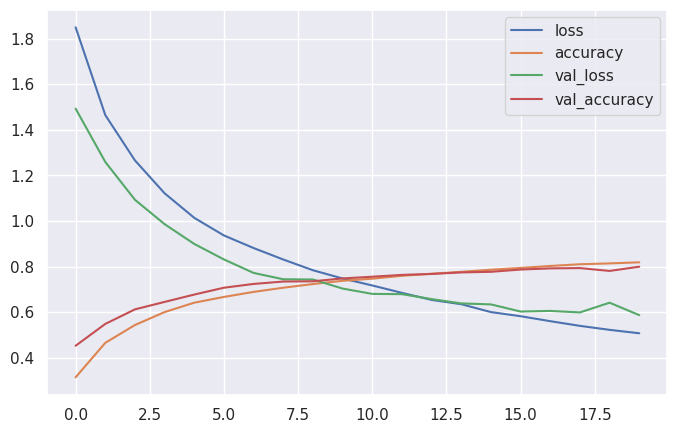

Test loss: 0.6109598875045776, Baseline model accuracy: 0.7954999804496765


In [12]:
# Improved model - Baseline + Dropout

# Use Dropout layer
# why do we need a dropout layer? to remove the overfitting issue in the nodes.

model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Dropout(0.2))
model_1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Dropout(0.2))
model_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Dropout(0.2))

# feature maps output from the feature extraction part of the model must be flattened.
# We can then interpret them with one or more fully connected layers,
# and then output a prediction. The output layer must have 10 nodes for the
# 10 classes and use the softmax activation function.

# example output part of the model
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_1.add(Dropout(0.2))
model_1.add(Dense(10, activation='softmax'))

# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Now train (fit) the model, specifying appropriate data and number of epochs (small here to save time)
# Save the history of metrics versus epochs - *always* keep this
history = model_1.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=16)

# Simple way to plot the history information (see later for more detail)
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.show()

# Now run the model on the test set and get results (loss and accuracy both reported)
# Evaluate the model on the test data
test_loss, test_accuracy = model_1.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss}, Baseline model accuracy: {test_accuracy}")


In [ ]:
# # drop out and data augmentation

# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))
# model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))
# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

# # feature maps output from the feature extraction part of the model must be flattened.
# # We can then interpret them with one or more fully connected layers,
# # and then output a prediction. The output layer must have 10 nodes for the
# # 10 classes and use the softmax activation function.

# # example output part of the model
# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))

# # compile model
# opt = SGD(learning_rate=0.001, momentum=0.9)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# # Create an instance of ImageDataGenerator with desired augmentation options
# image_generator = ImageDataGenerator(
#     rotation_range=20,      # Randomly rotate images by up to 20 degrees
#     width_shift_range=0.2,  # Randomly shift the image horizontally by up to 20% of the width
#     height_shift_range=0.2, # Randomly shift the image vertically by up to 20% of the height
#     horizontal_flip=True   # Randomly flip the image horizontally
# )

# # Generate augmented training data using the data generator
# train_generator = image_generator.flow(X_train, y_train, batch_size=16)

# # Train the model using the augmented training data generator
# history = model.fit_generator(train_generator,steps_per_epoch=2500,epochs=10,validation_data=(X_val,y_val)) # You should have validation data)

# #Simple way to plot the history information (see later for more detail)
# pd.DataFrame(history.history).plot(figsize=(8 , 5))
# plt.show()

# # Now run the model on the test set and get results (loss and accuracy both reported)
# # Evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
# print(f"Test loss: {test_loss}, Baseline model accuracy: {test_accuracy}")


### Baseline +  Dropout + Batch Normalization model

Epoch 1/20
2500/2500 [==============================] - 26s 9ms/step - loss: 1.6376 - accuracy: 0.4229 - val_loss: 1.2710 - val_accuracy: 0.5425
Epoch 2/20
2500/2500 [==============================] - 24s 10ms/step - loss: 1.2434 - accuracy: 0.5557 - val_loss: 1.0806 - val_accuracy: 0.6114
Epoch 3/20
2500/2500 [==============================] - 23s 9ms/step - loss: 1.0816 - accuracy: 0.6192 - val_loss: 0.9268 - val_accuracy: 0.6688
Epoch 4/20
2500/2500 [==============================] - 34s 13ms/step - loss: 0.9775 - accuracy: 0.6593 - val_loss: 0.8507 - val_accuracy: 0.6944
Epoch 5/20
2500/2500 [==============================] - 28s 11ms/step - loss: 0.9073 - accuracy: 0.6822 - val_loss: 0.7827 - val_accuracy: 0.7219
Epoch 6/20
2500/2500 [==============================] - 23s 9ms/step - loss: 0.8545 - accuracy: 0.7031 - val_loss: 0.7670 - val_accuracy: 0.7361
Epoch 7/20
2500/2500 [==============================] - 22s 9ms/step - loss: 0.8008 - accuracy: 0.7229 - val_loss: 0.7569 - val

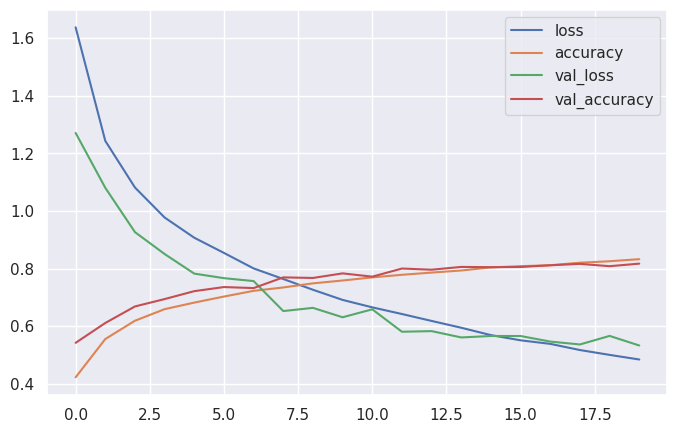

Test loss: 0.551399827003479, Baseline model accuracy: 0.8137000203132629


In [13]:
# Improved model Baseline +  Dropout + Batch Normalization

# Use Dropout layer + Batch Normalization
# we can add batch normalization in an effort to stabilize the learning and
# perhaps accelerate the learning process. To offset this acceleration,
# we can increase the regularization by changing the dropout from a fixed pattern to an increasing pattern.
#  why do we need a dropout layer? to remove the overfitting issue in the nodes.

model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.2))
model_2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.2))
model_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.2))

# feature maps output from the feature extraction part of the model must be flattened.
# We can then interpret them with one or more fully connected layers,
# and then output a prediction. The output layer must have 10 nodes for the
# 10 classes and use the softmax activation function.

# example output part of the model
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Dense(10, activation='softmax'))

# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Now train (fit) the model, specifying appropriate data and number of epochs (small here to save time)
# Save the history of metrics versus epochs - *always* keep this
history = model_2.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=16)

# Simple way to plot the history information (see later for more detail)
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.show()

# Now run the model on the test set and get results (loss and accuracy both reported)
# Evaluate the model on the test data
test_loss, test_accuracy = model_2.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss}, Baseline model accuracy: {test_accuracy}")


### State of the art VGG model

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
2500/2500 [==============================] - 26s 9ms/step - loss: 1.4588 - accuracy: 0.5000 - val_loss: 1.2718 - val_accuracy: 0.5567
Epoch 2/20
2500/2500 [==============================] - 22s 9ms/step - loss: 1.3174 - accuracy: 0.5418 - val_loss: 1.2659 - val_accuracy: 0.5576
Epoch 3/20
2500/2500 [==============================] - 24s 9ms/step - loss: 1.2782 - accuracy: 0.5576 - val_loss: 1.1959 - val_accuracy: 0.5858
Epoch 4/20
2500/2500 [==============================] - 23s 9ms/step - loss: 1.2517 - accuracy: 0.5677 - val_loss: 1.1952 - val_accuracy: 0.5837
Epoch 5/20
2500/2500 [==============================] - 23s 9ms/step - loss: 1.2286 - accuracy: 0.5745 - val_loss: 1.1798 - val_accuracy: 0.5893
Epoch 6/20
2500/2500 [==============================] - 22s 9ms/step - loss: 1.2115 - accuracy: 0.5787 - val_loss: 1.1650 - val_accuracy: 0.5957
Epoch 7/20
2500/2500 [==============================] - 23s 9ms/s

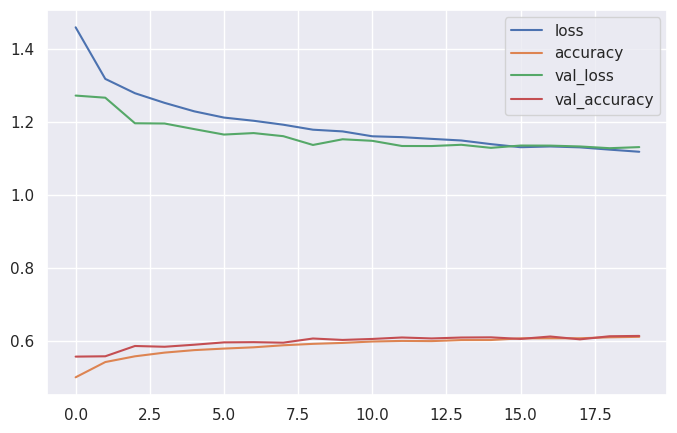

In [15]:
# Use state of the art VGG16 Model

from keras.applications.vgg16 import VGG16

# Create the VGG16 model for feature extraction (without top layers)
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   classes=10,
                   pooling= 'avg',
                   input_shape=(32, 32, 3))

# Freeze the weights of the VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
model_4 = Sequential()

# Add the VGG16 base model
model_4.add(base_model)

# Flatten the output from the VGG16 base model
model_4.add(Flatten())

# Add a fully connected layer with 100 units and ReLU activation
model_4.add(Dense(512, activation='relu'))

# # Add a BatchNormalization layer
model_4.add(BatchNormalization())

# # Add a Dropout layer with a 50% dropout rate
model_4.add(Dropout(0.2))

# Add the final output layer with 10 units (for 10 classes) and softmax activation
model_4.add(Dense(10, activation='softmax'))

# Compile the model with categorical cross-entropy loss and Adam optimizer
# compile model
opt = Adam(learning_rate=0.001)
model_4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Now train (fit) the model, specifying appropriate data and number of epochs (small here to save time)
# Save the history of metrics versus epochs - *always* keep this
history = model_4.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=16)

# Now run the model on the test set and get results (loss and accuracy both reported)
# Evaluate the model on the test data
test_loss, test_accuracy = model_4.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss}, Baseline model accuracy: {test_accuracy}")

# Simple way to plot the history information (see later for more detail)
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.show()


### Predict using the best model

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test dataset
y_pred = model_2.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)

# Convert true labels to class labels
y_true_labels = np.argmax(y_test, axis=-1)

# Calculate overall accuracy
overall_accuracy = np.mean(y_pred_labels == y_true_labels)

# Calculate accuracy for each individual letter
individual_letter_accuracy = {}
for label in range(len(class_names)):
    mask = y_true_labels == label
    correct_predictions = np.sum(y_pred_labels[mask] == label)
    total_samples = np.sum(mask)
    accuracy = correct_predictions / total_samples
    individual_letter_accuracy[class_names[label]] = accuracy

# Find the letter with the lowest individual accuracy
lowest_accuracy_letter = min(individual_letter_accuracy, key=individual_letter_accuracy.get)
lowest_accuracy = individual_letter_accuracy[lowest_accuracy_letter]

# Find the most common error (one letter being incorrectly labeled as another)
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
errors_matrix = conf_matrix - np.diag(np.diag(conf_matrix))
most_common_error = np.unravel_index(np.argmax(errors_matrix), errors_matrix.shape)

# Print the results
print("Overall Accuracy: {:.2f}%".format(overall_accuracy * 100))
print("Accuracy for Each Individual class with CNN model:")
for letter, accuracy in individual_letter_accuracy.items():
    print("Accuracy for {}: {:.2f}%".format(letter, accuracy * 100))
print("Image class with Lowest Accuracy: {} (Accuracy: {:.2f}%)".format(lowest_accuracy_letter, lowest_accuracy * 100))
print("Most Common Error (One class Incorrectly Labeled as Another): {} labeled as {}".format(class_names[most_common_error[0]], class_names[most_common_error[1]]))

313/313 [==============================] - 1s 3ms/step
Overall Accuracy: 81.37%
Accuracy for Each Individual class with CNN model:
Accuracy for airplane: 85.30%
Accuracy for automobile: 90.30%
Accuracy for bird: 66.90%
Accuracy for cat: 60.10%
Accuracy for deer: 87.00%
Accuracy for dog: 73.10%
Accuracy for frog: 91.80%
Accuracy for horse: 80.60%
Accuracy for ship: 90.30%
Accuracy for truck: 88.30%
Image class with Lowest Accuracy: cat (Accuracy: 60.10%)
Most Common Error (One class Incorrectly Labeled as Another): cat labeled as dog


In [51]:
# Print out the precision, recall and f1-score for each class
print(classification_report(y_true = y_true_labels,y_pred = y_pred_labels,digits=4,target_names = class_names))

              precision    recall  f1-score   support

    airplane     0.8194    0.8530    0.8359      1000
  automobile     0.9121    0.9030    0.9075      1000
        bird     0.8259    0.6690    0.7392      1000
         cat     0.7172    0.6010    0.6540      1000
        deer     0.6966    0.8700    0.7737      1000
         dog     0.7467    0.7310    0.7388      1000
        frog     0.7637    0.9180    0.8338      1000
       horse     0.9243    0.8060    0.8611      1000
        ship     0.8870    0.9030    0.8949      1000
       truck     0.8821    0.8830    0.8826      1000

    accuracy                         0.8137     10000
   macro avg     0.8175    0.8137    0.8121     10000
weighted avg     0.8175    0.8137    0.8121     10000



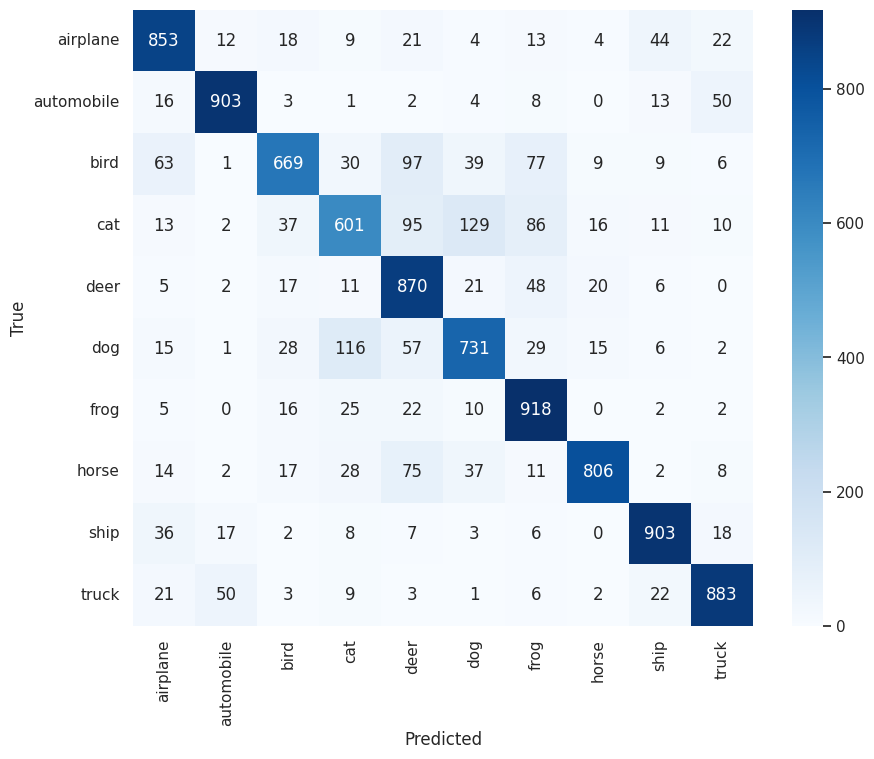

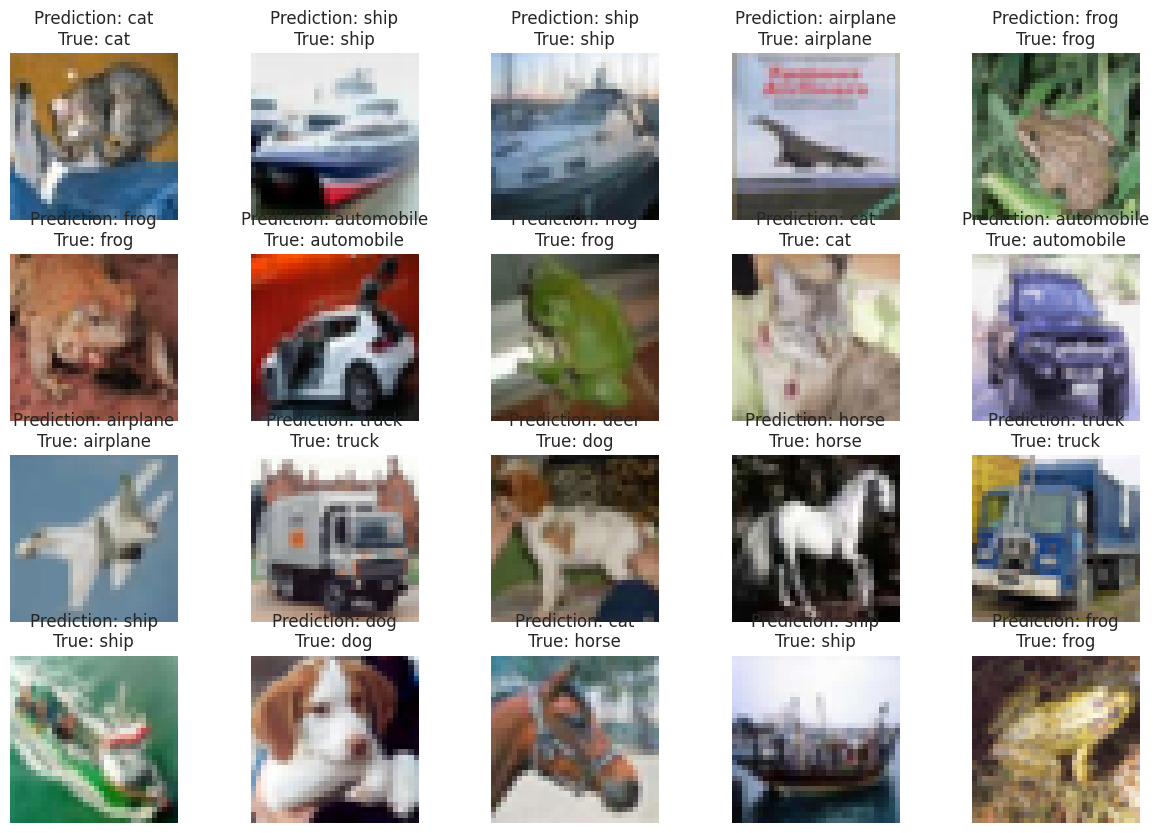

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Display confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display images and predictions for a subset of test samples for the first 20
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title("Prediction: {}\nTrue: {}".format(class_names[y_pred_labels[i]], class_names[y_true_labels[i]]))
    # plt.title(f"True: {y_test[i].argmax()}\nPred: {y_pred[i]}")
    plt.axis('off')
plt.show()
